## 📈 Sightings Analysis Playbook: Historical & Predictive

This notebook performs two main tasks:
1.  **Historical Analysis**: Processes JSON sightings data, filters by a selected source (e.g., 'Gist'), aggregates weekly counts, and visualizes the trend.
2.  **Adaptive Forecast**: Generates daily sighting counts for the **entire selected source**, determines if the trend is increasing or decreasing, and fits an appropriate **Logistic** or **Exponential Decay** curve to forecast the next 15 days.

In [91]:
# Import necessary libraries
import json
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
## Configuration

# --- FILE PATH, SOURCE SELECTION, and DATE RANGE ---
SIGHTINGS_EXPORT = "sightings_2025-12-01T20_51_28.694624+00_00.json"

# Choose the source to analyze (must match a key in the SOURCES dictionary below)
SELECTED_SOURCE_NAME = "Fediverse"

# Define a label for the forecast plot title (since we aren't using a `vuln_id` from an API)
FORECAST_LABEL = f"Sightings from {SELECTED_SOURCE_NAME} Sources"

SOURCES = {
    "Fediverse": [
        "infosec.exchange", "hachyderm.io", "mastodon.social", 
        "fosstodon.org", "social.circl.lu", "mstdn.ca", "cyberplace.social"
    ],
    "Bluesky": [
        "bsky.app"
    ],
    "MISP": [
        "MISP"
    ],
    "Gist": [
        "gist.github"
    ],
    "Nuclei": [
        "projectdiscovery/nuclei-templates"
    ],
    "Exploit-DB": [
        "exploit-db.com"
    ],
    "Metasploit": [
        "rapid7/metasploit-framework"
    ]
}

SIGHTING_SOURCE = SOURCES[SELECTED_SOURCE_NAME]

# Optional: Define date range to filter the analysis (inclusive)
START_DATE = "2025-01-01"
END_DATE = "2025-12-01"

# Convert date range to datetime objects for filtering
start_dt = pd.to_datetime(START_DATE).tz_localize(None)
end_dt = pd.to_datetime(END_DATE).tz_localize(None)

In [93]:
## Helper Functions
def extract_domain(url):
    if url:
        match = re.search(r"https?://([^/]+)", url)
        return match.group(1) if match else None
    return None

def extract_MISP(source):
    return "MISP" if "MISP" in source else None

def extract_Gist(source):
    return "gist.github" if "gist.github" in source else None

def extract_nuclei(source):
    return "projectdiscovery/nuclei-templates" if "projectdiscovery/nuclei-templates" in source else None

def extract_metasploit(source):
    return "rapid7/metasploit-framework" if "rapid7/metasploit-framework" in source else None

In [ ]:
## Data Loading and Filtering

# Load data from the specified JSON file
try:
    with open(SIGHTINGS_EXPORT, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"Successfully loaded {len(data)} sightings from {SIGHTINGS_EXPORT}.")
except FileNotFoundError:
    print(f"Error: File not found at '{SIGHTINGS_EXPORT}'. Please check the file path.")
    data = []
    
# --- 1. Filter Data and Aggregate for Weekly Plot (Per Domain) ---
sightings_per_week = defaultdict(lambda: defaultdict(int))

for sighting in data:
    sighting_source = sighting.get("source", "")
    if not sighting_source:
        continue

    # Determine the relevant domain/source identifier
    domain = ""
    match SELECTED_SOURCE_NAME:
        case "Fediverse":
            domain = extract_domain(sighting_source)
        case "Bluesky":
            domain = extract_domain(sighting_source)
        case "MISP":
            domain = extract_MISP(sighting_source)
        case "Gist":
            domain = extract_Gist(sighting_source)
        case "Nuclei":
            domain = extract_nuclei(sighting_source)
        case "Exploit-DB":
            domain = extract_domain(sighting_source)
        case "Metasploit":
            domain = extract_metasploit(sighting_source)
        case _:
            pass

    if not domain:
        continue

    # Filter by the relevant domain/source within the selected source group
    if domain and any(elem_domain in domain for elem_domain in SIGHTING_SOURCE):
        timestamp = sighting.get("creation_timestamp")
        if timestamp:
            # Handle ISO format conversion and timezone removal for comparison
            dt = datetime.fromisoformat(timestamp.replace("Z", "+00:00"))
            dt_no_tz = dt.replace(tzinfo=None)
            
            # Filter by date range
            if start_dt <= dt_no_tz <= end_dt:
                # Aggregate by Week Number (%Y-%W) for historical plot
                week = dt.strftime("%Y-%W")  
                sightings_per_week[week][domain] += 1

print(f"Processing complete. Found {len(sightings_per_week)} weeks with sightings for {SELECTED_SOURCE_NAME}.")

Successfully loaded 165201 sightings from sightings_2025-12-01T20_51_28.694624+00_00.json.
Processing complete. Found 45 weeks with sightings for Fediverse.


In [ ]:
## Historical Analysis: Weekly Counts Per Domain

# Convert the aggregated data to a Pandas DataFrame
df_weekly = pd.DataFrame(sightings_per_week).T.fillna(0).sort_index()

# Convert the week string index ('YYYY-WW') to a proper DateTimeIndex (set to Monday)
df_weekly.index = pd.to_datetime(df_weekly.index + '-1', format="%Y-%W-%w")

print("Head of the aggregated weekly data:")
display(df_weekly.head())

Head of the aggregated weekly data:


,infosec.exchange,mastodon.social,cyberplace.social,social.circl.lu,mstdn.ca,fosstodon.org,hachyderm.io
2025-01-01,336.0,4.0,0.0,0.0,2.0,0.0,0.0
2025-01-06,921.0,153.0,3.0,2.0,5.0,0.0,0.0
2025-01-13,1075.0,158.0,5.0,5.0,2.0,1.0,0.0
2025-01-20,524.0,104.0,0.0,0.0,4.0,0.0,4.0
2025-01-27,560.0,106.0,0.0,0.0,0.0,0.0,0.0


Plot saved to: Fediverse_sightings_per_week.png


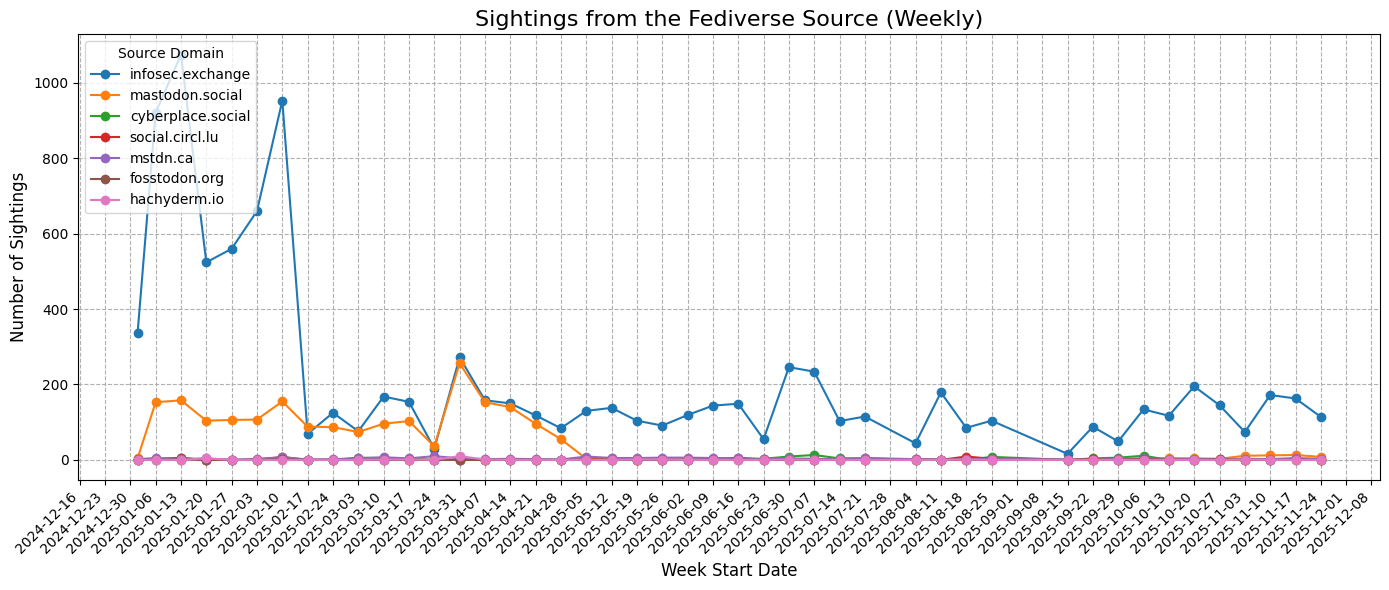

In [96]:
## Visualization: Weekly Trends

plt.figure(figsize=(14, 6))
for domain in df_weekly.columns:
    plt.plot(df_weekly.index, df_weekly[domain], marker="o", label=domain)

plt.title(f"Sightings from the {SELECTED_SOURCE_NAME} Source (Weekly)", fontsize=16)
plt.xlabel("Week Start Date", fontsize=12)
plt.ylabel("Number of Sightings", fontsize=12)
plt.legend(title="Source Domain", loc='upper left')
plt.grid(True, linestyle='--')

# X-axis formatting: Set a tick for the start of every week
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

output_filename = f"{SELECTED_SOURCE_NAME}_sightings_per_week.png"
plt.savefig(output_filename, dpi=300, bbox_inches="tight")
print(f"Plot saved to: {output_filename}")

plt.show()

--- 

## 🔮 Adaptive Forecast: Daily Counts

This section aggregates the *total* sightings for the selected source on a daily basis and applies an adaptive curve-fitting forecast. It selects between a **Logistic growth** model (for increasing trends) or an **Exponential decay** model (for decreasing trends) to predict the next 15 days.

In [ ]:
## Data Preparation for Forecast

# --- 2. Filter Data and Aggregate for Daily Forecast (Total Counts) ---

# Extract all filtered sightings for daily grouping
all_filtered_sightings = []
for sighting in data:
    sighting_source = sighting.get("source", "")
    if not sighting_source:
        continue
    
    # Determine domain/source identifier
    domain = ""
    match SELECTED_SOURCE_NAME:
        case "Fediverse":
            domain = extract_domain(sighting_source)
        case "Bluesky":
            domain = extract_domain(sighting_source)
        case "MISP":
            domain = extract_MISP(sighting_source)
        case "Gist":
            domain = extract_Gist(sighting_source)
        case "Nuclei":
            domain = extract_nuclei(sighting_source)
        case "Exploit-DB":
            domain = extract_domain(sighting_source)
        case "Metasploit":
            domain = extract_metasploit(sighting_source)
        case _:
            pass

    # Filter by the relevant domain/source within the selected source group
    if domain and any(elem_domain in domain for elem_domain in SIGHTING_SOURCE):
        timestamp = sighting.get("creation_timestamp")
        if timestamp:
            dt = datetime.fromisoformat(timestamp.replace("Z", "+00:00"))
            dt_no_tz = dt.replace(tzinfo=None)
            if start_dt <= dt_no_tz <= end_dt:
                all_filtered_sightings.append({"creation_date": dt.date()})

if not all_filtered_sightings:
    print("⚠️ No filtered data found for forecasting. Skipping forecast task.")
    exit()
    
# Convert to DataFrame and count sightings per day
df_sightings = pd.DataFrame(all_filtered_sightings)
daily_counts = df_sightings.groupby("creation_date").size().rename("sightings")

# Convert to pandas Series indexed by datetime
daily_series = pd.Series(daily_counts)
daily_series.index = pd.to_datetime(daily_series.index)
daily_series.index.name = "date"
daily_series = daily_series.sort_index()

print("Daily series head for forecast:")
print(daily_series.head())

Daily series head for forecast:
date
2025-01-01      5
2025-01-02    179
2025-01-03     81
2025-01-04     45
2025-01-05     32
Name: sightings, dtype: int64


In [ ]:
## Adaptive Model Fitting and Forecasting

# --- Helper models ---
def logistic(t, L, k, t0):
    """Logistic growth model: L / (1 + exp(-k * (t - t0)))"""
    return L / (1 + np.exp(-k * (t - t0)))

def exp_decay(t, a, b, c):
    """Exponential decay model: a * exp(-b * t) + c"""
    return a * np.exp(-b * t) + c

# --- Prepare data ---
t = np.arange(len(daily_series)) # Time index (days since first sighting)
y = daily_series.values # Sighting counts

if len(y) < 3:
    print("⚠️ Not enough data points to fit a model (needs at least 3 days).")
    exit()

# --- Detect growth or decay phase ---
trend_slope = np.polyfit(t, y, 1)[0] # Slope of a linear fit to detect trend
model_type = "logistic" if trend_slope > 0 else "decay"
print(f"Trend slope: {trend_slope:.3f}. Selected model: {model_type.capitalize()}")

# --- Fit appropriate model with bounds ---
try:
    # Bounds ensure all fitted parameters are non-negative.
    if model_type == "logistic":
        # Initial guess
        L0 = max(y) * 1.5 if max(y) > 0 else 10
        k0 = 0.3
        t0 = np.median(t)
        popt, pcov = curve_fit(
            logistic, t, y, p0=[L0, k0, t0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
            maxfev=10000
        )
        forecast_func = lambda tt: logistic(tt, *popt)
    else:
        # Initial guess
        a0 = max(y)
        b0 = 0.3
        c0 = min(y)
        popt, pcov = curve_fit(
            exp_decay, t, y, p0=[a0, b0, c0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
            maxfev=10000
        )
        forecast_func = lambda tt: exp_decay(tt, *popt)
except RuntimeError:
    print("⚠️ Curve fitting failed. Exiting forecast task.")
    exit()

# --- Forecast next days ---
future_steps = 60
last_date = daily_series.index.max()

# Build future date index
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq="D")

# Compute t values for forecasting
t_future = np.arange(len(daily_series), len(daily_series) + future_steps)

# Forecast values for future days and clamp to zero (sightings cannot be negative)
forecast_future_values = np.maximum(forecast_func(t_future), 0).round().astype(int)

Trend slope: -0.319. Selected model: Decay


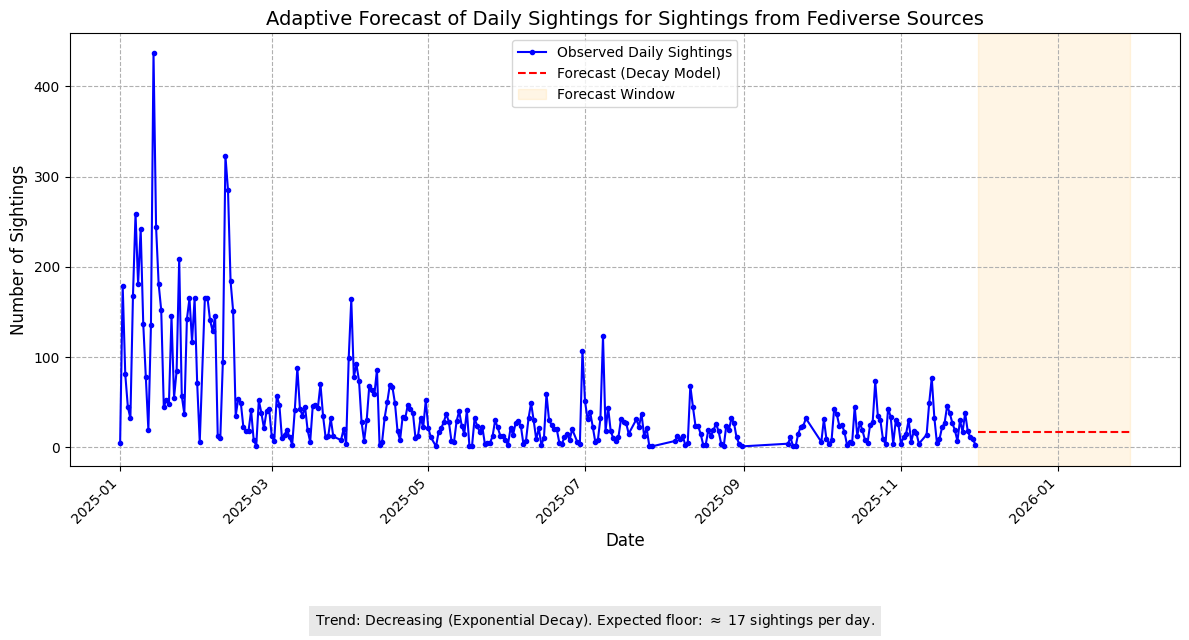

In [ ]:
## Visualization: Forecast Plot

plt.figure(figsize=(12, 6))

# Plot observed data
plt.plot(daily_series.index, daily_series.values, "bo-", markersize=3, label="Observed Daily Sightings")

# Plot forecast data
plt.plot(forecast_dates, forecast_future_values, "r--", label=f"Forecast ({model_type.capitalize()} Model)")

# Highlight the forecast region
plt.axvspan(forecast_dates[0], forecast_dates[-1], color="orange", alpha=0.1, label="Forecast Window")

plt.title(f"Adaptive Forecast of Daily Sightings for {FORECAST_LABEL}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Sightings", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--')

# --- Overlay textual summary below plot ---
if model_type == "logistic":
    L_param = popt[0]
    summary = rf"Trend: Rising (Logistic Growth). Expected peak/plateau: $\approx$ {L_param:.0f} sightings per day."
elif model_type == "decay":
    C_param = popt[2]
    summary = rf"Trend: Decreasing (Exponential Decay). Expected floor: $\approx$ {C_param:.0f} sightings per day."
else:
    summary = "No trend detected or model failed."

plt.figtext(0.5, -0.05, summary, ha="center", fontsize=10, bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout for summary text
plt.show()